# Mutation analysis

This tutorial illustrates how to estimate and visualize the effect of single-nucleotide mutations on DNA methylation.

## Table of Contents
* [Initialization](#Initialization)
* [Downloading a pre-trained models](#Downloading-a-pre-trained-models)
* [Creating DeepCpG data files](#Creating-DeepCpG-data-files)
* [Computing effects](#Computing-effects)
* [Visualizing effects](#Visualizing-effects)

## Initialization

We first important the relevant libraries and initialize global variables.

In [1]:
import os
from os import path as pt

import h5py as h5
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
example_dir = "../../data" # Directory with example data.
cpg_dir = pt.join(example_dir, "cpg") # Directory with CpG profiles.
dna_dir = pt.join(example_dir, "dna/mm10") # Directory with DNA sequences.

data_dir = "./data" # Directory with data files
model_dir = "./model" # Directory with DeepCpG model
snp_dir = "./snp" # Directory with results of mutation analysis

## Downloading a pre-trained models

We will use the DNA model trained on serum mESCs from *Smallwood et al. (2014)* to compute effects, which we download from the DeepCpG model zoo with `dcpg_download.py`. You can use any DeepCpG DNA model or Joint model instead. In case of using a Joint model, you will obtain mutation effects conditioned on observed neighoring CpG sites.

In [4]:
!dcpg_download.py \
    Smallwood2014_serum_dna \
    --out_dir {model_dir}

INFO (2017-04-10 10:04:37,594): Downloading model ...
INFO (2017-04-10 10:04:37,594): Model URL: http://www.ebi.ac.uk/~angermue/deepcpg/alias/1754b5bbc21a8257663acc52e657f69c
--2017-04-10 10:04:37--  http://www.ebi.ac.uk/~angermue/deepcpg/alias/1754b5bbc21a8257663acc52e657f69c
Resolving www.ebi.ac.uk... 193.62.193.80
Connecting to www.ebi.ac.uk|193.62.193.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124853155 (119M) [text/plain]
Saving to: ‘./model/model.zip’

./model/model.zip   100%[===================>] 119.07M  23.4MB/s    in 5.1s    

2017-04-10 10:04:42 (23.3 MB/s) - ‘./model/model.zip’ saved [124853155/124853155]

Archive:  ./model/model.zip
  inflating: ./model/model.h5        
  inflating: ./model/model.json      
  inflating: ./model/model_weights.h5  
  inflating: ./model/model_weights_train.h5  
  inflating: ./model/model_weights_val.h5  
INFO (2017-04-10 10:04:44,478): Done!


## Creating DeepCpG data files

Next, we use `dcpg_data.py` to extract DNA sequence windows for which we will compute effects. You can skip this step if you have already created data files.

In [5]:
!dcpg_data.py \
    --cpg_profiles {cpg_dir}/*.tsv \
    --dna_files {dna_dir} \
    --out_dir {data_dir} \
    --dna_wlen 1001 \
    --chromo 4 \
    --nb_sample 1000

INFO (2017-04-10 10:04:45,482): Reading CpG profiles ...
INFO (2017-04-10 10:04:45,482): ../../data/cpg/BS27_1_SER.tsv
INFO (2017-04-10 10:04:51,976): ../../data/cpg/BS27_3_SER.tsv
INFO (2017-04-10 10:04:56,622): ../../data/cpg/BS27_5_SER.tsv
INFO (2017-04-10 10:05:03,578): ../../data/cpg/BS27_6_SER.tsv
INFO (2017-04-10 10:05:08,929): ../../data/cpg/BS27_8_SER.tsv
INFO (2017-04-10 10:05:14,082): 1000 samples
INFO (2017-04-10 10:05:14,082): --------------------------------------------------------------------------------
INFO (2017-04-10 10:05:14,082): Chromosome 4 ...
INFO (2017-04-10 10:05:14,092): 1000 / 1000 (100.0%) sites matched minimum coverage filter
INFO (2017-04-10 10:05:17,074): Chunk 	1 / 1
INFO (2017-04-10 10:05:17,078): Extracting DNA sequence windows ...
INFO (2017-04-10 10:05:17,561): Done!


## Computing effects

Now we can run `dcpg_snp.py` to compute the effect of single-nucleotide mutations for the created data files using the downloaded model. With `--targets mean var`, `dcpg_snp.py` computes the effect on the mean methylation rate and variance across cells. With `--store_inputs`, input DNA sequence windows will be stored in the output file (`--out_file`), which is useful for analyzing effects.

In [6]:
effects_file = "./effects.h5"
!dcpg_snp.py \
    {data_dir}/*.h5 \
    --model_files {model_dir} \
    --out_file {effects_file} \
    --targets mean var \
    --store_inputs \
    --nb_sample 1000

Using TensorFlow backend.
INFO (2017-04-10 10:05:20,698): Loading model ...
INFO (2017-04-10 10:05:22,474): Reading data ...
INFO (2017-04-10 10:05:22,476): Computing effects ...
INFO (2017-04-10 10:05:22,482):  128/1000 (12.8%)
INFO (2017-04-10 10:05:24,142):  256/1000 (25.6%)
INFO (2017-04-10 10:05:25,429):  384/1000 (38.4%)
INFO (2017-04-10 10:05:26,742):  512/1000 (51.2%)
INFO (2017-04-10 10:05:28,024):  640/1000 (64.0%)
INFO (2017-04-10 10:05:29,347):  768/1000 (76.8%)
INFO (2017-04-10 10:05:30,610):  896/1000 (89.6%)
INFO (2017-04-10 10:05:31,909): 1000/1000 (100.0%)
INFO (2017-04-10 10:05:33,003): Done!


The output file is a HDF5 file with following datasets:
* `/chromo`: The chromosome of the DNA sequence window.
* `/pos`: The position of the DNA sequence window on the chromosome.
* `/dna`: The input DNA sequence window. Only present if `--store_inputs` was used.
* `/mean`: The effect of each nucleotide in the DNA sequence window on the mean methylation rate across cells.
* `/var`: The effect of each nucleotide in the DNA sequence window on the variance across cells.

In [7]:
!h5ls -r {effects_file}

/                        Group
/chromo                  Dataset {1000}
/dna                     Dataset {1000, 1001, 4}
/mean                    Dataset {1000, 1001, 4}
/pos                     Dataset {1000}
/var                     Dataset {1000, 1001, 4}


Here, `1000` is number of DNA sequence windows, `1001` the length of DNA sequence windows, and `4` the number of nucleotides.

## Visualizing effects

To visualize effects, we first read the output data of `dcpg_snp.py` using [h5py](http://www.h5py.org/):

In [8]:
h5_file = h5.File(effects_file, 'r')
data = {key: value.value for key, value in h5_file.items()}
h5_file.close()

Next, we compute the maximum absolute effect across nucleotides, averaged over all sequence windows:

In [9]:
global_effects = dict()
for target in ['mean', 'var']:
    global_effects[target] = np.mean(np.max(np.abs(data[target]), axis=2), axis=0)

These can be now visualized at different resolutions:

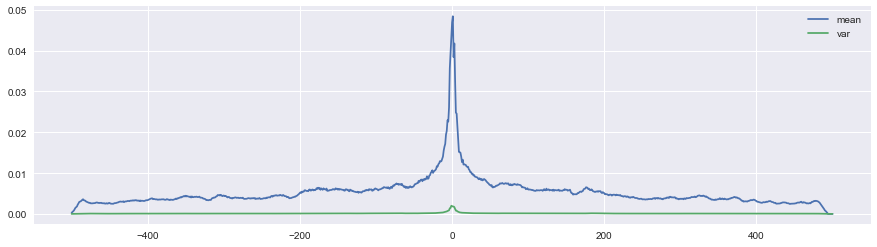

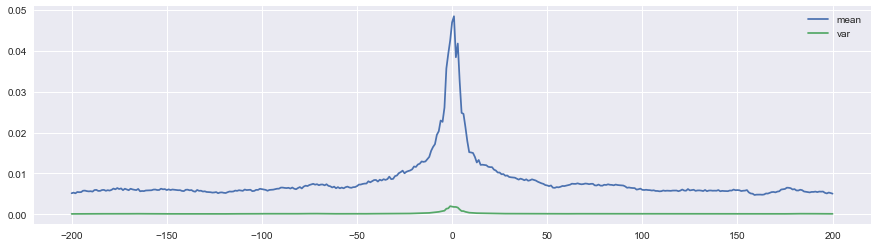

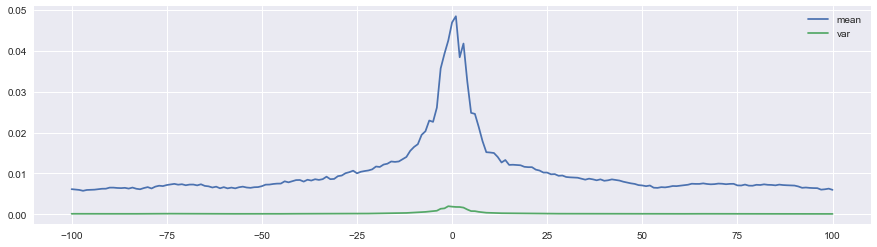

In [10]:
def slice_ctr(d, wlen, axis=0):
    _wlen = d.shape[axis]
    ctr = _wlen // 2
    dwlen = wlen // 2
    idx = slice(ctr - dwlen, ctr + dwlen + 1)
    if axis == 0:
        return d[idx]
    elif axis == 1:
        return d[:, idx]
    elif axis == 2:
        return d[:, :, idx]
    
def plot_global_effects(effects, wlen=None):
    if wlen:
        effects = {key: slice_ctr(value, wlen) for key, value in effects.items()}
    wlen = len(list(effects.values())[0])
    fig, ax = plt.subplots(figsize=(15, 4))
    x = np.arange(wlen) - (wlen // 2)
    for key, value in effects.items():
        ax.plot(x, value, label=key)
    ax.legend()
    
plot_global_effects(global_effects)
plot_global_effects(global_effects, 401)
plot_global_effects(global_effects, 201)

The plots show that mutations close to the target CpG site have the largest effect
and that mutations have a stronger effect on the mean methylation rate than on the variance between cells.

In addition to visualizing average effects, we can visualize the effects for individual sequences:

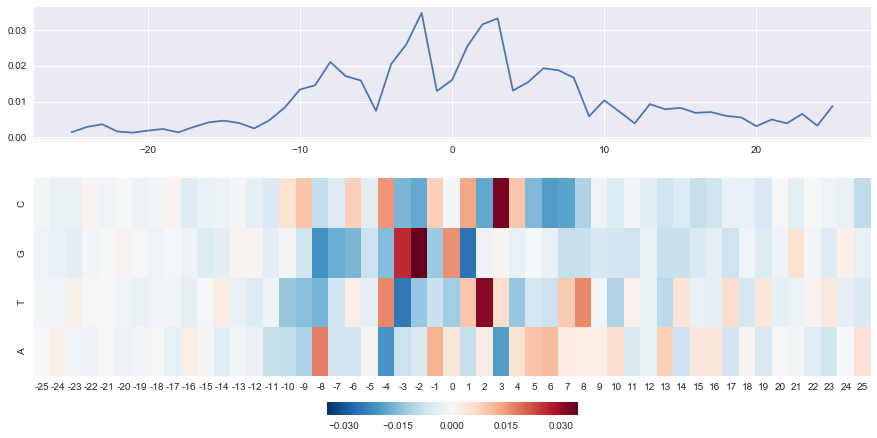

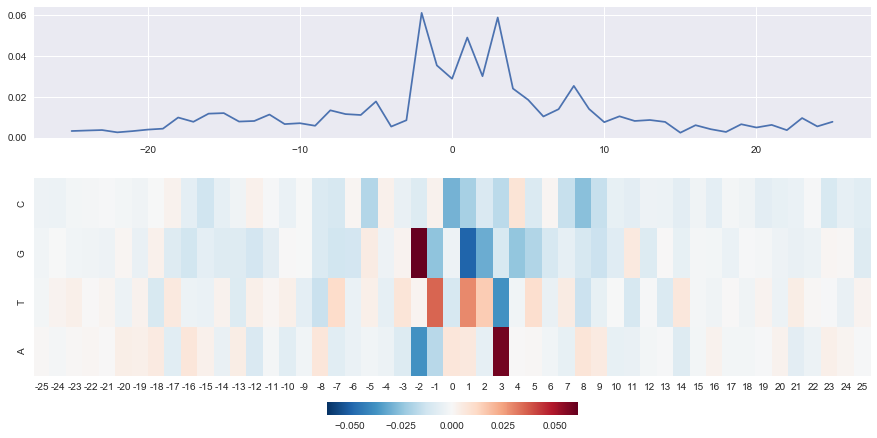

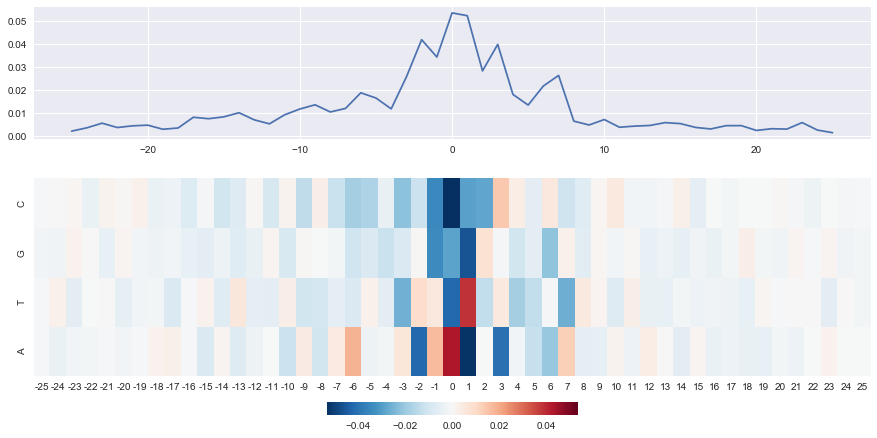

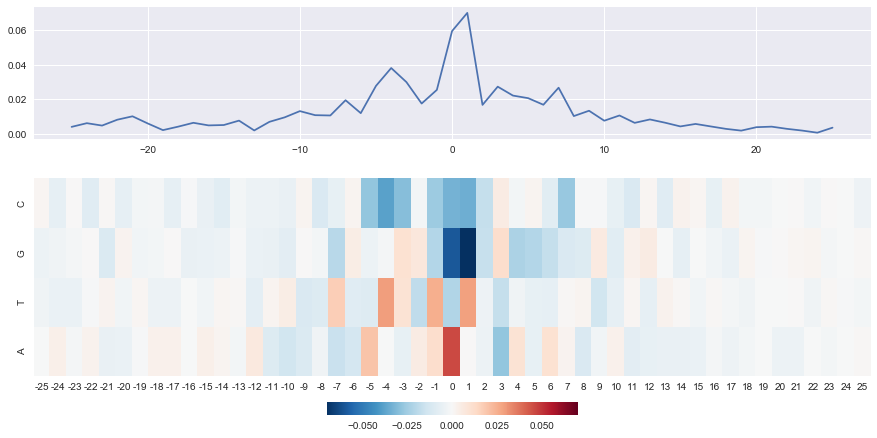

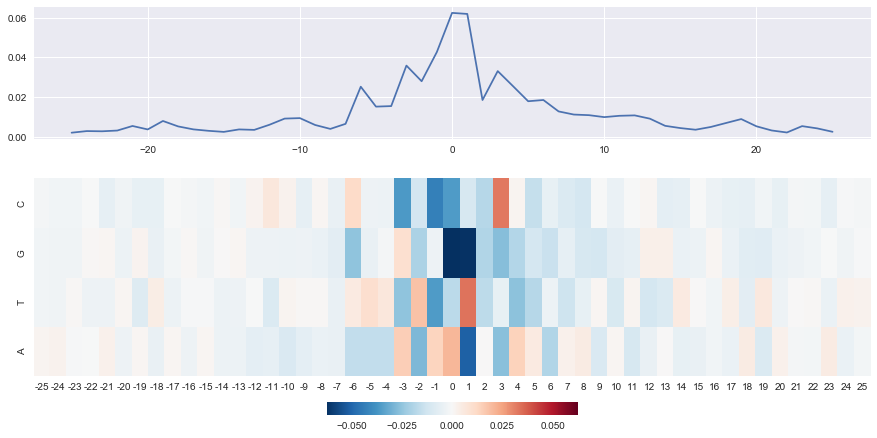

In [11]:
def select_seq(data, chromo, pos, target='mean'):
    idx = (data['chromo'] == chromo.encode()) & (data['pos'] == pos)
    assert idx.sum() == 1
    return data[target][idx].squeeze().T

def plot_seq_effects(effects, wlen=51):
    ctr = effects.shape[1] // 2
    dwlen = wlen // 2
    effects = effects[:, ctr-dwlen:ctr+dwlen+1]

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8),
                           gridspec_kw={'height_ratios': [1, 2]})
    x = np.arange(wlen) - dwlen
    ax[0].plot(x, np.max(np.abs(effects), axis=0))
    sns.heatmap(effects, ax=ax[1],
                cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 0.3})
    ax[1].set_xticklabels(x)
    ax[1].set_yticklabels(['A', 'T', 'G', 'C'])
    
for pos in data['pos'][:5]:
    effects = select_seq(data, '4', pos)
    plot_seq_effects(effects)

The heatmap shows the effect of each nucleotide within a window of 51 bp centered on the target CpG site, and the top row the maximum absolute effect across nucleotides. We used `select_seq` to select the first 5 sequences. Instead you can use `data['chromo']` and `data['pos']` to select any CpG site in which you are interested in.

In [12]:
data['chromo'][:50]

array([b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4',
       b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4',
       b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4',
       b'4', b'4', b'4', b'4', b'4'], 
      dtype='|S2')

In [13]:
data['pos'][:50]

array([3050345, 3050726, 3050920, 3050988, 3051050, 3051142, 3051157, 3051239, 3051283, 3051396,
       3051406, 3051489, 3052071, 3052259, 3052344, 3052721, 3052840, 3052932, 3053139, 3053186,
       3053251, 3053393, 3053430, 3053621, 3053959, 3054265, 3054340, 3054368, 3054551, 3054752,
       3054779, 3055553, 3055916, 3056267, 3056303, 3056424, 3057057, 3057090, 3058493, 3058579,
       3058816, 3058875, 3058902, 3058954, 3059016, 3059199, 3059743, 3060042, 3061225, 3061500], dtype=int32)